In [58]:
#import libraries
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
import sklearn

In [59]:
%store -r cook_county_gdf_year
%store -r CC_nodeaths
cook_county_gdf = cook_county_gdf_year

In [63]:
cook_county_gdf.year.isna().sum()

56

In [64]:
cook_county_gdf['year'].fillna(9999, inplace=True)

,year,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,deaths


In [66]:
cook_county_gdf[cook_county_gdf['year']==9999].shape

(56, 15)

In [67]:
cook_county_gdf['GEOID'].nunique() #now we have all census tracts

1332

In [71]:
columns_to_keep = ['STATEFP', 'COUNTYFP', 'TRACTCE','NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER',
       'INTPTLAT', 'INTPTLON', 'geometry']

gdf_annual = cook_county_gdf.groupby(['GEOID', 'year']).agg({'deaths': 'sum', **{col: 'first' for col in columns_to_keep}}).reset_index()

In [72]:

gdf_annual

,GEOID,year,deaths,STATEFP,COUNTYFP,TRACTCE,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,17031010100,2014.0,1,17,031,010100,101,Census Tract 101,G5020,S,379511,0,+42.0212553,-087.6698301,"POLYGON ((-87.67720 42.02294, -87.67628 42.022..."
1,17031010100,2015.0,1,17,031,010100,101,Census Tract 101,G5020,S,379511,0,+42.0212553,-087.6698301,"POLYGON ((-87.67720 42.02294, -87.67628 42.022..."
2,17031010100,2016.0,3,17,031,010100,101,Census Tract 101,G5020,S,379511,0,+42.0212553,-087.6698301,"POLYGON ((-87.67720 42.02294, -87.67628 42.022..."
3,17031010100,2017.0,2,17,031,010100,101,Census Tract 101,G5020,S,379511,0,+42.0212553,-087.6698301,"POLYGON ((-87.67720 42.02294, -87.67628 42.022..."
4,17031010100,2019.0,2,17,031,010100,101,Census Tract 101,G5020,S,379511,0,+42.0212553,-087.6698301,"POLYGON ((-87.67720 42.02294, -87.67628 42.022..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5888,17031980000,2022.0,3,17,031,980000,9800,Census Tract 9800,G5020,S,19890200,92402,+41.9794191,-087.9024376,"POLYGON ((-87.94025 42.00717, -87.94017 42.007..."
5889,17031980000,2023.0,4,17,031,980000,9800,Census Tract 9800,G5020,S,19890200,92402,+41.9794191,-087.9024376,"POLYGON ((-87.94025 42.00717, -87.94017 42.007..."
5890,17031980100,2018.0,1,17,031,980100,9801,Census Tract 9801,G5020,S,2981781,0,+41.7859813,-087.7509001,"POLYGON ((-87.76230 41.79274, -87.76206 41.792..."
5891,17031980100,2022.0,1,17,031,980100,9801,Census Tract 9801,G5020,S,2981781,0,+41.7859813,-087.7509001,"POLYGON ((-87.76230 41.79274, -87.76206 41.792..."


In [73]:
gdf_annual['GEOID'].nunique() 

1332

In [74]:
(gdf_annual['year'] == 9999).sum()

56

### Making DF square - one year for each tract



In [75]:
gdf_annual.loc[gdf_annual['year'] == 9999, 'deaths'] = 0

# Replace 9999 with 2015 in the 'year' column
gdf_annual['year'].replace(9999, 2015, inplace=True)

In [76]:
##uses nested for loops - not exactly the most efficient 

years = range(2015, 2024)
updated_rows = []

for tract in gdf_annual['GEOID'].unique():
    existing_years = set(gdf_annual[gdf_annual['GEOID'] == tract]['year'])
    missing_years = set(years) - existing_years
    
    for year in missing_years:
        new_row = {'GEOID': tract, 
                   'year': year, 
                   'deaths': 0}
        
        updated_rows.append(new_row)

gdf_annual = pd.concat([gdf_annual, pd.DataFrame(updated_rows)], ignore_index=True)

In [77]:
unique_tracts = gdf_annual['GEOID'].unique()

for tract in unique_tracts:
    tract_rows = gdf_annual[gdf_annual['GEOID'] == tract]
    non_na_row = tract_rows.dropna().iloc[0]  # Get the first row without any NAs
    
    for column in columns_to_keep:
        gdf_annual.loc[(gdf_annual['GEOID'] == tract) & gdf_annual[column].isna(), column] = non_na_row[column]

In [79]:
gdf_annual = gdf_annual[gdf_annual['year']!=2014]

In [81]:
gdf_annual.shape #should be 11988, 15

(11988, 15)

In [82]:
#Any NAs in data frame?

has_na = gdf_annual.isna().any().any()

if has_na:
    print("There are missing values in the dataframe.")
else:
    print("There are no missing values in the dataframe.")


There are no missing values in the dataframe.


In [83]:
#confirms all years for each GEOID present
years = range(2015, 2024)  

for geoid in gdf_annual['GEOID'].unique():
    for year in years:
        if not ((gdf_annual['GEOID'] == geoid) & (gdf_annual['year'] == year)).any():
            print("Missing row for GEOID {} in year {}".format(geoid, year))


In [84]:
gdf_annual = gpd.GeoDataFrame(gdf_annual, geometry='geometry')

In [85]:
type(gdf_annual)

geopandas.geodataframe.GeoDataFrame

In [86]:
#create timestep column
gdf_annual = gdf_annual.sort_values(by=['GEOID', 'year'])

# Group the DataFrame by 'geoid' and assign a unique timestep value based on the order of years
gdf_annual['timestep'] = gdf_annual.groupby('GEOID').cumcount() + 1

In [87]:
print(gdf_annual['timestep'].unique())

[1 2 3 4 5 6 7 8 9]


In [88]:
gdf_annual.columns = ['GEOID', 'year', 'deaths', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'NAME',
       'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'lat',
       'lon', 'geometry', 'timestep']

## Tables & Graphs

In [89]:
gdf_annual['year'] = pd.to_datetime(gdf_annual['year'].astype(int).astype(str), format='%Y').dt.year

In [90]:
gdf_annual

,GEOID,year,deaths,STATEFP,COUNTYFP,TRACTCE,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,lat,lon,geometry,timestep
1,17031010100,2015,1,17,031,010100,101,Census Tract 101,G5020,S,379511.0,0.000000e+00,+42.0212553,-087.6698301,"POLYGON ((-87.67720 42.02294, -87.67628 42.022...",1
2,17031010100,2016,3,17,031,010100,101,Census Tract 101,G5020,S,379511.0,0.000000e+00,+42.0212553,-087.6698301,"POLYGON ((-87.67720 42.02294, -87.67628 42.022...",2
3,17031010100,2017,2,17,031,010100,101,Census Tract 101,G5020,S,379511.0,0.000000e+00,+42.0212553,-087.6698301,"POLYGON ((-87.67720 42.02294, -87.67628 42.022...",3
5893,17031010100,2018,0,17,031,010100,101,Census Tract 101,G5020,S,379511.0,0.000000e+00,+42.0212553,-087.6698301,"POLYGON ((-87.67720 42.02294, -87.67628 42.022...",4
4,17031010100,2019,2,17,031,010100,101,Census Tract 101,G5020,S,379511.0,0.000000e+00,+42.0212553,-087.6698301,"POLYGON ((-87.67720 42.02294, -87.67628 42.022...",5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12169,17031990000,2019,0,17,031,990000,9900,Census Tract 9900,G5020,S,0.0,1.717072e+09,+41.9739391,-087.4002947,"POLYGON ((-87.74156 42.15323, -87.72176 42.153...",5
12170,17031990000,2020,0,17,031,990000,9900,Census Tract 9900,G5020,S,0.0,1.717072e+09,+41.9739391,-087.4002947,"POLYGON ((-87.74156 42.15323, -87.72176 42.153...",6
12171,17031990000,2021,0,17,031,990000,9900,Census Tract 9900,G5020,S,0.0,1.717072e+09,+41.9739391,-087.4002947,"POLYGON ((-87.74156 42.15323, -87.72176 42.153...",7
12172,17031990000,2022,0,17,031,990000,9900,Census Tract 9900,G5020,S,0.0,1.717072e+09,+41.9739391,-087.4002947,"POLYGON ((-87.74156 42.15323, -87.72176 42.153...",8


In [91]:
sparsity_df = pd.DataFrame(columns=['year', 'Total Deaths', 'Sparsity Rate'])

years = range(2015, 2023)
for year in years:
    year_df = gdf_annual[gdf_annual['year'] == year]
    zero_deaths_count = year_df[year_df['deaths'] == 0].shape[0]
    total_count = year_df.shape[0]
    sparsity_rate = (zero_deaths_count / total_count) * 100
    total_deaths = year_df['deaths'].sum()
    sparsity_df = pd.concat([sparsity_df, pd.DataFrame({'year': [year], 'Total Deaths': [total_deaths], 'Sparsity Rate': [sparsity_rate]})], ignore_index=True)


raw_sparsity = sparsity_df['Sparsity Rate']
sparsity_df['Sparsity Rate'] = sparsity_df['Sparsity Rate'].round(3).astype(str) + '%'
print(sparsity_df)

   year Total Deaths Sparsity Rate
0  2015          616       67.342%
1  2016         1029       53.754%
2  2017         1109       53.303%
3  2018         1078       54.429%
4  2019         1210       52.102%
5  2020         1687       43.619%
6  2021         1791       43.168%
7  2022         1851       43.018%


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

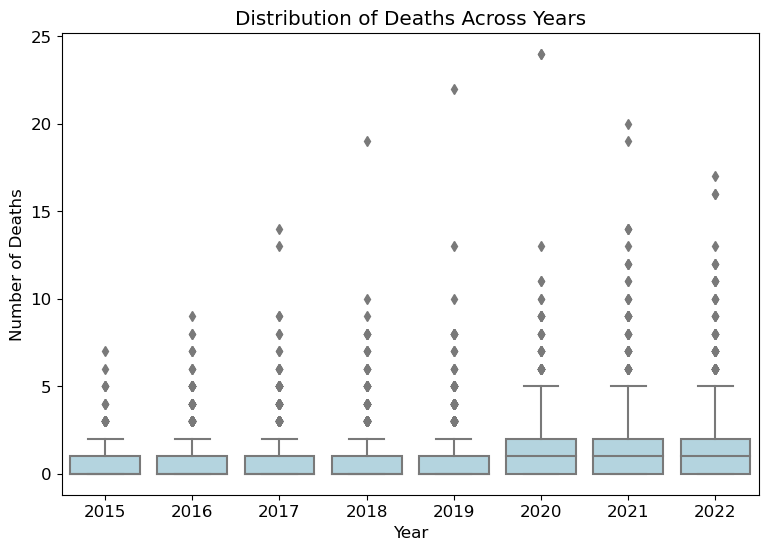

In [92]:
plt.figure(figsize=(9, 6))
df_no23 = gdf_annual[gdf_annual['year'] != 2023]
sns.boxplot(x='year', y='deaths', data=df_no23, color='lightblue')

plt.xlabel('Year')
plt.ylabel('Number of Deaths')
plt.title('Distribution of Deaths Across Years')

plt.show()


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

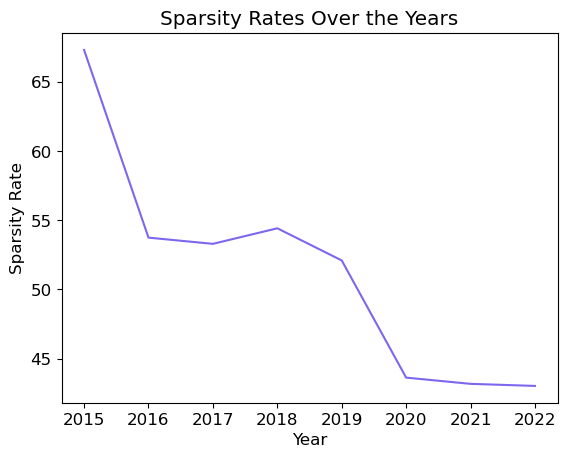

In [96]:
plt.plot(range(2015, 2023), raw_sparsity, color='mediumslateblue')

font = {'family': 'Go Mono for Powerline',
        'weight': 'normal',
        'size': 12}
plt.rc('font', **font)


plt.xlabel('Year')
plt.ylabel('Sparsity Rate')
plt.title('Sparsity Rates Over the Years')
plt.grid(False)

plt.show()

### store gdf

In [94]:
gdf_annual = gdf_annual[gdf_annual['year'] != 2023]
gdf_annual = gdf_annual[gdf_annual['year'] != 2014]
%store gdf_annual

Stored 'gdf_annual' (GeoDataFrame)


findfont: Font family 'Go Mono for Powerline' not found.
findfont: Font family 'Go Mono for Powerline' not found.
findfont: Font family 'Go Mono for Powerline' not found.
findfont: Font family 'Go Mono for Powerline' not found.
findfont: Font family 'Go Mono for Powerline' not found.
findfont: Font family 'Go Mono for Powerline' not found.
findfont: Font family 'Go Mono for Powerline' not found.
findfont: Font family 'Go Mono for Powerline' not found.
findfont: Font family 'Go Mono for Powerline' not found.
findfont: Font family 'Go Mono for Powerline' not found.
findfont: Font family 'Go Mono for Powerline' not found.
findfont: Font family 'Go Mono for Powerline' not found.
findfont: Font family 'Go Mono for Powerline' not found.
findfont: Font family 'Go Mono for Powerline' not found.
findfont: Font family 'Go Mono for Powerline' not found.
findfont: Font family 'Go Mono for Powerline' not found.
findfont: Font family 'Go Mono for Powerline' not found.
findfont: Font family 'Go Mono 

<Axes: >

findfont: Font family 'Go Mono for Powerline' not found.
findfont: Font family 'Go Mono for Powerline' not found.
findfont: Font family 'Go Mono for Powerline' not found.
findfont: Font family 'Go Mono for Powerline' not found.
findfont: Font family 'Go Mono for Powerline' not found.
findfont: Font family 'Go Mono for Powerline' not found.
findfont: Font family 'Go Mono for Powerline' not found.
findfont: Font family 'Go Mono for Powerline' not found.
findfont: Font family 'Go Mono for Powerline' not found.
findfont: Font family 'Go Mono for Powerline' not found.
findfont: Font family 'Go Mono for Powerline' not found.
findfont: Font family 'Go Mono for Powerline' not found.
findfont: Font family 'Go Mono for Powerline' not found.
findfont: Font family 'Go Mono for Powerline' not found.
findfont: Font family 'Go Mono for Powerline' not found.
findfont: Font family 'Go Mono for Powerline' not found.
findfont: Font family 'Go Mono for Powerline' not found.
findfont: Font family 'Go Mono 

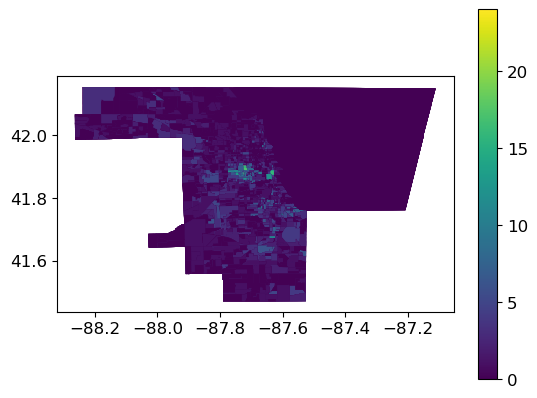

In [103]:
gdf_annual[gdf_annual['year']==2015].plot('deaths', legend=True)


In [104]:
gdf_annual.deaths.max()

24

In [105]:
gdf_annual

,GEOID,year,deaths,STATEFP,COUNTYFP,TRACTCE,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,lat,lon,geometry,timestep
1,17031010100,2015,1,17,031,010100,101,Census Tract 101,G5020,S,379511.0,0.000000e+00,+42.0212553,-087.6698301,"POLYGON ((-87.67720 42.02294, -87.67628 42.022...",1
2,17031010100,2016,3,17,031,010100,101,Census Tract 101,G5020,S,379511.0,0.000000e+00,+42.0212553,-087.6698301,"POLYGON ((-87.67720 42.02294, -87.67628 42.022...",2
3,17031010100,2017,2,17,031,010100,101,Census Tract 101,G5020,S,379511.0,0.000000e+00,+42.0212553,-087.6698301,"POLYGON ((-87.67720 42.02294, -87.67628 42.022...",3
5893,17031010100,2018,0,17,031,010100,101,Census Tract 101,G5020,S,379511.0,0.000000e+00,+42.0212553,-087.6698301,"POLYGON ((-87.67720 42.02294, -87.67628 42.022...",4
4,17031010100,2019,2,17,031,010100,101,Census Tract 101,G5020,S,379511.0,0.000000e+00,+42.0212553,-087.6698301,"POLYGON ((-87.67720 42.02294, -87.67628 42.022...",5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12168,17031990000,2018,0,17,031,990000,9900,Census Tract 9900,G5020,S,0.0,1.717072e+09,+41.9739391,-087.4002947,"POLYGON ((-87.74156 42.15323, -87.72176 42.153...",4
12169,17031990000,2019,0,17,031,990000,9900,Census Tract 9900,G5020,S,0.0,1.717072e+09,+41.9739391,-087.4002947,"POLYGON ((-87.74156 42.15323, -87.72176 42.153...",5
12170,17031990000,2020,0,17,031,990000,9900,Census Tract 9900,G5020,S,0.0,1.717072e+09,+41.9739391,-087.4002947,"POLYGON ((-87.74156 42.15323, -87.72176 42.153...",6
12171,17031990000,2021,0,17,031,990000,9900,Census Tract 9900,G5020,S,0.0,1.717072e+09,+41.9739391,-087.4002947,"POLYGON ((-87.74156 42.15323, -87.72176 42.153...",7
